# Build a user-item collaborative filtering music recommender model

In this series of notebooks, we analyzed and curated the Million Song Dataset(MSD) and EchoNet user listening count dataset. From there, we built a user-item collaborative filering music recommender using the Surprise module. The end goal is implementing a recommender model for Spotify songs as part of our MuseX Music Exploration Dashboard project. To transfer the information from MSD to Spotify dataset, the MSD songs were mapped to songs in the Spotify 600k dataset using Fuzzymatcher.

This notebook covers the data processing, analysis and dataset curation, and some model training code.

In [2]:
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
import seaborn as sns

## Loading dataset
### Million Song Dataset - Unique Tracks: artist - song

In [2]:
msd_tracks_df = pd.read_csv('msd_unique_tracks.txt', delimiter='<SEP>', names=['artist_id','song_id', 'artist', 'title'])
msd_tracks_df.drop_duplicates(['song_id'], inplace=True)
msd_tracks_df

/home/r2feng/.local/lib/python3.7/site-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.


,artist_id,song_id,artist,title
0,TRMMMYQ128F932D901,SOQMMHC12AB0180CB8,Faster Pussy cat,Silent Night
1,TRMMMKD128F425225D,SOVFVAK12A8C1350D9,Karkkiautomaatti,Tanssi vaan
2,TRMMMRX128F93187D9,SOGTUKN12AB017F4F1,Hudson Mohawke,No One Could Ever
3,TRMMMCH128F425532C,SOBNYVR12A8C13558C,Yerba Brava,Si Vos Querés
4,TRMMMWA128F426B589,SOHSBXH12A8C13B0DF,Der Mystic,Tangle Of Aspens
...,...,...,...,...
999995,TRYYYUS12903CD2DF0,SOTXAME12AB018F136,Kiko Navarro,O Samba Da Vida
999996,TRYYYJO128F426DA37,SOXQYIQ12A8C137FBB,Kuldeep Manak,Jago Chhadeo
999997,TRYYYMG128F4260ECA,SOHODZI12A8C137BB3,Gabriel Le Mar,Novemba
999998,TRYYYDJ128F9310A21,SOLXGOR12A81C21EB7,Elude,Faraday


### EchoNet Taste Profile: song - user - play count

In [3]:
playcount_df = pd.read_csv('train_triplets.txt', delimiter='\t', names=['user_id', 'song_id', 'count'])

In [4]:
playcount_df[:10]

,user_id,song_id,count
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAKIMP12A8C130995,1
1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAPDEY12A81C210A9,1
2,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBBMDR12A8C13253B,2
3,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBFNSP12AF72A0E22,1
4,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBFOVM12A58A7D494,1
5,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBNZDC12A6D4FC103,1
6,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBSUJE12A6D4F8CF5,2
7,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBVFZR12A6D4F8AE3,1
8,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBXALG12A8C13C108,1
9,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBXHDL12A81C204C0,1


In [5]:
print(len(playcount_df))

48373586


#### We have explored the data before. We know that a user listens to an average of 26 songs. After a little more exploration, we discovered that a song is listened to by an average of 200 users, with minimum 48 and maximum 8277 users.

In [6]:
# Get how many user have listened to each song
user_counts = playcount_df.groupby('user_id')['song_id'].count()

user_counts

user_id
00000b722001882066dff9d2da8a775658053ea0    12
00001638d6189236866af9bbf309ae6c2347ffdc    14
0000175652312d12576d9e6b84f600caa24c4715    12
00001cf0dce3fb22b0df0f3a1d9cd21e38385372    18
0000267bde1b3a70ea75cf2b2d216cb828e3202b    25
                                            ..
ffffdc6c89988cd6119067769162948eacf8b670    51
ffffe07df4bb5fd929efe42c5728f3a0c1621277    14
fffff3e690fcda840b716ce7249d8935ff3323fc    15
fffff67d54a40927c93d03bd6c816b034b59f087    81
fffff9534445f481b6ab91c345500083d2ce4df1    40
Name: song_id, Length: 1019318, dtype: int64

In [7]:
# Filter users which have listen to at least 16 songs
user_ten_id = user_counts[user_counts > 16].index.to_list()
len(user_ten_id)

742116

In [8]:
# Get how many user have listened to each song
song_counts = playcount_df.groupby('song_id')['user_id'].count()
print(len(song_counts))

# Get songs which have been listened at least 4 times
song_ten_id = song_counts[song_counts > 200].index.to_list()
print(len(song_ten_id))

# Filtered the dataset to keep only those users with more than 16 listened
df_song_reduced = playcount_df[(playcount_df['user_id'].isin(user_ten_id)) & 
                           (playcount_df['song_id'].isin(song_ten_id))].reset_index(drop=True)
df_song_reduced

384546
41001


,user_id,song_id,count
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAKIMP12A8C130995,1
1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAPDEY12A81C210A9,1
2,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBBMDR12A8C13253B,2
3,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBFNSP12AF72A0E22,1
4,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBFOVM12A58A7D494,1
...,...,...,...
36192630,b7815dbb206eb2831ce0fe040d0aa537e2e800f7,SOUHHHH12AF729E4AF,2
36192631,b7815dbb206eb2831ce0fe040d0aa537e2e800f7,SOUJVIT12A8C1451C1,1
36192632,b7815dbb206eb2831ce0fe040d0aa537e2e800f7,SOUSMXX12AB0185C24,1
36192633,b7815dbb206eb2831ce0fe040d0aa537e2e800f7,SOWYSKH12AF72A303A,3


In [9]:
# Join track_df & playcount_df
merged_file = 'msd_songs.csv'
msd_songs = pd.merge(df_song_reduced, msd_tracks_df, on='song_id', how="left")
msd_songs.to_csv(merged_file,index=False)

In [17]:
msd_songs[:10]

,user_id,song_id,count,artist_id,artist,title
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAKIMP12A8C130995,1,TRIQAUQ128F42435AD,Jack Johnson,The Cove
1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAPDEY12A81C210A9,1,TRIRLYL128F42539D1,Billy Preston,Nothing from Nothing
2,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBBMDR12A8C13253B,2,TRMHBXZ128F4238406,Paco De Lucia,Entre Dos Aguas
3,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBFNSP12AF72A0E22,1,TRYQMNI128F147C1C7,Josh Rouse,Under Cold Blue Stars
4,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBFOVM12A58A7D494,1,TRAHZNE128F9341B86,The Dead 60s,Riot Radio (Soundtrack Version)
5,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBSUJE12A6D4F8CF5,2,TRPLAXZ128F4292406,Jorge Drexler,12 segundos de oscuridad
6,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBXALG12A8C13C108,1,TRZYZWL128F4277AD2,Eric Hutchinson,Food Chain (Album Version)
7,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBXHDL12A81C204C0,1,TRHNCIR128F42334A5,Kanye West,Stronger
8,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBYHAJ12A6701BF1D,1,TRYBNIB128F428E704,Jack Johnson,Constellations
9,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOCNMUH12A6D4F6E6D,1,TRGOSGL128F1471533,Zero 7,You're My Flame [Album Version]


## Load Merged MSD dataset with listen counts

In [1]:
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
merged_file = 'msd_songs.csv'
msd_songs = pd.read_csv(merged_file)

In [3]:
msd_songs = msd_songs.rename(columns={'song_id':'song_id_MSD'})
msd_songs

,user_id,song_id_MSD,count,artist_id,artist,title
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAKIMP12A8C130995,1,TRIQAUQ128F42435AD,Jack Johnson,The Cove
1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAPDEY12A81C210A9,1,TRIRLYL128F42539D1,Billy Preston,Nothing from Nothing
2,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBBMDR12A8C13253B,2,TRMHBXZ128F4238406,Paco De Lucia,Entre Dos Aguas
3,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBFNSP12AF72A0E22,1,TRYQMNI128F147C1C7,Josh Rouse,Under Cold Blue Stars
4,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBFOVM12A58A7D494,1,TRAHZNE128F9341B86,The Dead 60s,Riot Radio (Soundtrack Version)
...,...,...,...,...,...,...
36192630,b7815dbb206eb2831ce0fe040d0aa537e2e800f7,SOUHHHH12AF729E4AF,2,TRKUAEO128F933ABFC,Eminem / Obie Trice / Stat Quo / Bobby Creekwa...,We're Back
36192631,b7815dbb206eb2831ce0fe040d0aa537e2e800f7,SOUJVIT12A8C1451C1,1,TRRNFHH128F92D262D,Rise Against,Savior
36192632,b7815dbb206eb2831ce0fe040d0aa537e2e800f7,SOUSMXX12AB0185C24,1,TRSLDDC12903CC36E7,Usher featuring will.i.am,OMG
36192633,b7815dbb206eb2831ce0fe040d0aa537e2e800f7,SOWYSKH12AF72A303A,3,TRNJQAM128F14557AF,matchbox twenty,Downfall (Album Version)


In [27]:
msd2spf = pd.merge(msd_songs, msd2spf, how='inner', on=['song_id_MSD'])
msd2spf

,user_id,song_id_MSD,count,artist_id,artist,title,score,song_id_SPF
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAKIMP12A8C130995,1,TRIQAUQ128F42435AD,Jack Johnson,The Cove,0.440233,27uOuxKlQE9c1i4bh89Wg5
1,7c86176941718984fed11b7c0674ff04c029b480,SOAKIMP12A8C130995,1,TRIQAUQ128F42435AD,Jack Johnson,The Cove,0.440233,27uOuxKlQE9c1i4bh89Wg5
2,76235885b32c4e8c82760c340dc54f9b608d7d7e,SOAKIMP12A8C130995,3,TRIQAUQ128F42435AD,Jack Johnson,The Cove,0.440233,27uOuxKlQE9c1i4bh89Wg5
3,250c0fa2a77bc6695046e7c47882ecd85c42d748,SOAKIMP12A8C130995,1,TRIQAUQ128F42435AD,Jack Johnson,The Cove,0.440233,27uOuxKlQE9c1i4bh89Wg5
4,3f73f44560e822344b0fb7c6b463869743eb9860,SOAKIMP12A8C130995,6,TRIQAUQ128F42435AD,Jack Johnson,The Cove,0.440233,27uOuxKlQE9c1i4bh89Wg5
...,...,...,...,...,...,...,...,...
18747582,5c2d0d9194262ea44a55d32fc8defcf650f41996,SOHZIPR12A8C1350D3,1,TRNGKZN128F92CBEB7,Michael Jackson,Butterflies,0.876819,0rT9f5BSZrZ6DvzfBEckG0
18747583,85bb0545b3f3aff3d149baeec60911a577cfce74,SOHZIPR12A8C1350D3,6,TRNGKZN128F92CBEB7,Michael Jackson,Butterflies,0.876819,0rT9f5BSZrZ6DvzfBEckG0
18747584,078134c9a39fc34657d7bade7a6b6dd753a0159d,SOHZIPR12A8C1350D3,1,TRNGKZN128F92CBEB7,Michael Jackson,Butterflies,0.876819,0rT9f5BSZrZ6DvzfBEckG0
18747585,8b4c719e712d45cc8273023e40134b4e69d9394c,SOHZIPR12A8C1350D3,1,TRNGKZN128F92CBEB7,Michael Jackson,Butterflies,0.876819,0rT9f5BSZrZ6DvzfBEckG0


In [30]:
df_reduced = msd2spf.loc[:, ['user_id', 'song_id_SPF', 'count']]
df_reduced


,user_id,song_id_SPF,count
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,27uOuxKlQE9c1i4bh89Wg5,1
1,7c86176941718984fed11b7c0674ff04c029b480,27uOuxKlQE9c1i4bh89Wg5,1
2,76235885b32c4e8c82760c340dc54f9b608d7d7e,27uOuxKlQE9c1i4bh89Wg5,3
3,250c0fa2a77bc6695046e7c47882ecd85c42d748,27uOuxKlQE9c1i4bh89Wg5,1
4,3f73f44560e822344b0fb7c6b463869743eb9860,27uOuxKlQE9c1i4bh89Wg5,6
...,...,...,...
18747582,5c2d0d9194262ea44a55d32fc8defcf650f41996,0rT9f5BSZrZ6DvzfBEckG0,1
18747583,85bb0545b3f3aff3d149baeec60911a577cfce74,0rT9f5BSZrZ6DvzfBEckG0,6
18747584,078134c9a39fc34657d7bade7a6b6dd753a0159d,0rT9f5BSZrZ6DvzfBEckG0,1
18747585,8b4c719e712d45cc8273023e40134b4e69d9394c,0rT9f5BSZrZ6DvzfBEckG0,1


In [31]:
df_reduced.to_csv('SPF_user_listen_count.csv', index=False)

In [29]:
len(set(msd2spf['song_id_SPF']))

15357

In [4]:
## 41K songs in MSD have user listening data
msd_list_unique = msd_songs.loc[:,['song_id_MSD', 'artist','title']]
msd_list_unique.drop_duplicates(inplace=True, keep='first')
len(msd_list_unique)

41001

In [5]:
msd_list_unique

,song_id_MSD,artist,title
0,SOAKIMP12A8C130995,Jack Johnson,The Cove
1,SOAPDEY12A81C210A9,Billy Preston,Nothing from Nothing
2,SOBBMDR12A8C13253B,Paco De Lucia,Entre Dos Aguas
3,SOBFNSP12AF72A0E22,Josh Rouse,Under Cold Blue Stars
4,SOBFOVM12A58A7D494,The Dead 60s,Riot Radio (Soundtrack Version)
...,...,...,...
1247915,SOJSHPW12A58A79D68,Firefall,Strange Way (LP Version)
1265439,SODYPUW12AF729F2FC,Sonic Youth,Disconnection Notice
1312290,SOHKFEZ12AB01871E6,Pull Tiger Tail,Say What You Cant Say
1504954,SOKSYTG12A8C136080,Poisonblack,Only You Can Tear Me Apart


In [12]:
msd_list_unique.to_csv('msd_list_unique.csv', index=False)

## Load Spotify 600K dataset

In [3]:
sp600_tracks = 'spotify600k_tracks.csv'
sp600_data = 'spotify600k_data_o.csv'

sp_tracks_df = pd.read_csv(sp600_tracks)

In [4]:
sp_tracks_df

,id,name,popularity,duration_ms,explicit,artists,id_artists,release_date,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
0,35iwgR4jXetI318WEWsa1Q,Carve,6,126903,0,['Uli'],['45tIt06XoI0Iio4LBEVpls'],1922-02-22,0.645,0.4450,0,-13.338,1,0.4510,0.674,0.744000,0.1510,0.1270,104.851,3
1,021ht4sdgPcrDgSk7JTbKY,Capítulo 2.16 - Banquero Anarquista,0,98200,0,['Fernando Pessoa'],['14jtPCOoNZwquk5wd9DxrY'],1922-06-01,0.695,0.2630,0,-22.136,1,0.9570,0.797,0.000000,0.1480,0.6550,102.009,1
2,07A5yehtSnoedViJAZkNnc,Vivo para Quererte - Remasterizado,0,181640,0,['Ignacio Corsini'],['5LiOoJbxVSAMkBS2fUm3X2'],1922-03-21,0.434,0.1770,1,-21.180,1,0.0512,0.994,0.021800,0.2120,0.4570,130.418,5
3,08FmqUhxtyLTn6pAh6bk45,El Prisionero - Remasterizado,0,176907,0,['Ignacio Corsini'],['5LiOoJbxVSAMkBS2fUm3X2'],1922-03-21,0.321,0.0946,7,-27.961,1,0.0504,0.995,0.918000,0.1040,0.3970,169.980,3
4,08y9GfoqCWfOGsKdwojr5e,Lady of the Evening,0,163080,0,['Dick Haymes'],['3BiJGZsyX9sJchTqcSA7Su'],1922,0.402,0.1580,3,-16.900,0,0.0390,0.989,0.130000,0.3110,0.1960,103.220,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
586667,5rgu12WBIHQtvej2MdHSH0,云与海,50,258267,0,['阿YueYue'],['1QLBXKM5GCpyQQSVMNZqrZ'],2020-09-26,0.560,0.5180,0,-7.471,0,0.0292,0.785,0.000000,0.0648,0.2110,131.896,4
586668,0NuWgxEp51CutD2pJoF4OM,blind,72,153293,0,['ROLE MODEL'],['1dy5WNgIKQU6ezkpZs4y8z'],2020-10-21,0.765,0.6630,0,-5.223,1,0.0652,0.141,0.000297,0.0924,0.6860,150.091,4
586669,27Y1N4Q4U3EfDU5Ubw8ws2,What They'll Say About Us,70,187601,0,['FINNEAS'],['37M5pPGs6V1fchFJSgCguX'],2020-09-02,0.535,0.3140,7,-12.823,0,0.0408,0.895,0.000150,0.0874,0.0663,145.095,4
586670,45XJsGpFTyzbzeWK8VzR8S,A Day At A Time,58,142003,0,"['Gentle Bones', 'Clara Benin']","['4jGPdu95icCKVF31CcFKbS', '5ebPSE9YI5aLeZ1Z2g...",2021-03-05,0.696,0.6150,10,-6.212,1,0.0345,0.206,0.000003,0.3050,0.4380,90.029,4


In [7]:
sp_tracks_df.popularity.mean()

27.570052772247525

## Map MSD user listening counts to Spotify song collection

To implement a collaborative filtering algorithm for Spotify users, we need to leverage the existing user listening counts dataset (MSD dataset x EchoNet dataset) by mapping the unique MSD songs to the most similar Spotify songs. This matching was realized in the last section of notebook using fuzzymatcher.

In [5]:
# For the purpose of recommending songs, we selected the top 75% popular artists' tracks to guarantee quality
sp_tracks = sp_tracks_df.loc[sp_tracks_df.popularity>25, ['id', 'name', 'artists', 'popularity']]
sp_tracks

,id,name,artists,popularity
149,2wAfHM7Whz67VFbdanhZlk,Nobody Knows You When You're Down and Out,['Bessie Smith'],41
150,3eMrYc092k7SIJfWJ7oasR,Weather Bird,"['Louis Armstrong', 'Earl Hines']",38
151,2AZgaYZSwUosJD71J2N2Zo,'Tain't Nobody's Bizness If I Do,['Bessie Smith'],30
152,7lRFR5GJCxK87ZbVMtQSeS,Ain't Misbehavin',['Louis Armstrong'],28
153,6XTvSCqGLLH0vzQQRn55hz,"Empty Bed Blues, Pt. 1",['Bessie Smith'],27
...,...,...,...,...
586667,5rgu12WBIHQtvej2MdHSH0,云与海,['阿YueYue'],50
586668,0NuWgxEp51CutD2pJoF4OM,blind,['ROLE MODEL'],72
586669,27Y1N4Q4U3EfDU5Ubw8ws2,What They'll Say About Us,['FINNEAS'],70
586670,45XJsGpFTyzbzeWK8VzR8S,A Day At A Time,"['Gentle Bones', 'Clara Benin']",58


In [6]:
msd_list_unique = pd.read_csv('msd_list_unique.csv')

In [7]:
# This fuzzy matching part is computational & memory intensive
# May need to be run multiple times to finish all entries.

import fuzzymatcher
import time
import gc

file_name = "MSD2spotify.csv"
num_songs = len(msd_list_unique)
chunk_size = 1000
match_score_threshold = 0.3

with open(file_name, 'a') as f:
    songs_matched = 0
    for pos in range(0, num_songs, chunk_size):
        start = time.perf_counter()

        left_df = msd_list_unique.iloc[pos:pos+chunk_size,:]
        right_df = sp_tracks
        left_on = ['title', 'artist']
        right_on = ['name', 'artists']

        matched_results = fuzzymatcher.fuzzy_left_join(left_df,
                                                    right_df,
                                                    left_on,
                                                    right_on)
        decent_matches = matched_results.loc[matched_results.best_match_score > match_score_threshold, :]
        songs_matched += len(decent_matches)
        decent_matches.to_csv(f, header=False, index=False, mode='a')
        print((pos+chunk_size)*100/num_songs, '% songs finished processing, # songs macthed: ', songs_matched)
        
        del matched_results
        del decent_matches
        gc.collect()
        
        end = time.perf_counter()
        print('Time Lapsed: ',end-start)

85.36377161532646 % songs finished processing, # songs macthed:  529
Time Lapsed:  146.86452440405264
87.8027365186215 % songs finished processing, # songs macthed:  1085
Time Lapsed:  139.70013622101396
90.24170142191655 % songs finished processing, # songs macthed:  1665
Time Lapsed:  140.17761842696927
92.68066632521158 % songs finished processing, # songs macthed:  2247
Time Lapsed:  143.41582419001497
95.11963122850662 % songs finished processing, # songs macthed:  2790
Time Lapsed:  141.08317466196604
97.55859613180166 % songs finished processing, # songs macthed:  3343
Time Lapsed:  142.2019731369801
99.99756103509671 % songs finished processing, # songs macthed:  3902
Time Lapsed:  142.79241791716777
102.43652593839175 % songs finished processing, # songs macthed:  3903
Time Lapsed:  138.81027055112645


In [ ]:
# Matching Time Lasped per Chunk: 
# ~40s for 100 songs
# ~90s for 1,000 songs
# ~400s for 10,000 songs

In [3]:
matched_results = pd.read_csv("spotify2MSD.csv", names=['score','id_left', 'id_right',
                                                        'song_id_SPF', 'song_SPF', 'artist_SPF', 'popularity',
                                                        'song_id_MSD', 'song_MSD', 'artist_MSD'])
matched_results.drop(columns=['id_left', 'id_right'], inplace=True)
matched_results

,score,song_id_SPF,song_SPF,artist_SPF,popularity,song_id_MSD,song_MSD,artist_MSD
0,0.751256,2wAfHM7Whz67VFbdanhZlk,Nobody Knows You When You're Down and Out,['Bessie Smith'],41,SOBIQRS12AB0185E55,Otis Redding,Nobody Knows You ( When You're Down And Out ) ...
1,1.052367,7lRFR5GJCxK87ZbVMtQSeS,Ain't Misbehavin',['Louis Armstrong'],28,SOEDLZQ12A8C133B68,Louis Armstrong,Ain't Misbehavin'
2,1.728431,2I74IqSUjq6Wyyj0RrbxID,Sitting On Top Of The World,['Mississippi Sheiks'],27,SOHFZTX12AB017F163,Mississippi Sheiks,Sitting On Top Of The World
3,0.702761,7bLCaNKMPIAipcqQ29VtIc,"Yira, Yira",['Carlos Gardel'],27,SOBJYNB12AB017FE27,Carlos Gardel,Yira yira
4,0.341858,6ALpCzjVWFQJRwKIM8he8F,The Way You Look Tonight,['Fred Astaire'],36,SOKIWMA12AB017F330,Maroon 5,The Way You Look Tonight
...,...,...,...,...,...,...,...,...
32315,0.991075,4ura5pqFYsLbv5krHtRwla,The Desperation's Gone,['NOFX'],35,SODENOW12A58A7E785,NOFX,The Desperation's Gone
32316,0.368691,0ds5D8mJ5K2jOxCdKFJHEb,Sad Eyes,['Enrique Iglesias'],35,SOLZIUS12A8C138863,Enrique Iglesias,Sweet Isabel
32317,1.334204,3EermXPNw0ZRp2u4prbnAm,I Have Always Loved You,['Enrique Iglesias'],33,SOLFRUW12AB0183942,Enrique Iglesias,I Have Always Loved You
32318,0.941201,5Bk1ArPcnMgeQzSqLjqaSW,Down with the Sickness,['Disturbed'],40,SOPGREN12A6701EA2E,Disturbed,Down With The Sickness (Album Version)


In [22]:
# Find 1 to 1 mapping from MSD_unique to SPF - take spotify song with highest score
mapping = matched_results.loc[:, ['score', 'song_id_SPF', 'song_id_MSD',]]
MSD_id_group = mapping.groupby(['song_id_MSD'], sort=False)['score'].max()
msd2spf = mapping.sort_values('score', ascending=False).drop_duplicates(['song_id_MSD'])

msd2spf

,score,song_id_SPF,song_id_MSD
16799,4.846004,1qZGjqfS5QoZQ5BKAhAauT,SOUUBHY12A6D4FD39E
27194,4.199550,79oQb66jALYYKX1hn4qs4p,SOMSPUJ12A6702064A
18628,3.923052,1ejjdxSSIYBaWavDfSdcTq,SOBJXPJ12AB0186089
30634,3.814314,73A0DxzMGDhVGsvHQSaaBq,SOMFGHC12A67020641
8898,3.803406,4VZPYvMTByQytb6F3MKP4w,SOHYYVI12A6D4F98A6
...,...,...,...
26451,0.250355,22iMNpRod9XBdpe7LKYIFO,SOQNYZF12AB017F763
4909,0.250268,0ZljhJQbm611zf5ttHz43n,SOQGIGB12AB018C0D4
13969,0.250183,3s0h3pyKFrS3XX6ZLBPx6s,SOXKNPW12AB01806F1
12349,0.250145,2NwH11vRqwyAkNmdVNaKhu,SOZEXNN12AB0183FBE


## Matrix Factorization Model 

In [10]:
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
import seaborn as sns

from surprise import SVD
from surprise import Dataset, Reader
from surprise import accuracy
from surprise.model_selection import train_test_split
from surprise.model_selection import GridSearchCV
from surprise.model_selection import cross_validate

In [11]:
df_song_reduced = pd.read_csv('SPF_user_listen_count.csv')
df_song_reduced

,user_id,song_id_SPF,count
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,27uOuxKlQE9c1i4bh89Wg5,1
1,7c86176941718984fed11b7c0674ff04c029b480,27uOuxKlQE9c1i4bh89Wg5,1
2,76235885b32c4e8c82760c340dc54f9b608d7d7e,27uOuxKlQE9c1i4bh89Wg5,3
3,250c0fa2a77bc6695046e7c47882ecd85c42d748,27uOuxKlQE9c1i4bh89Wg5,1
4,3f73f44560e822344b0fb7c6b463869743eb9860,27uOuxKlQE9c1i4bh89Wg5,6
...,...,...,...
18747582,5c2d0d9194262ea44a55d32fc8defcf650f41996,0rT9f5BSZrZ6DvzfBEckG0,1
18747583,85bb0545b3f3aff3d149baeec60911a577cfce74,0rT9f5BSZrZ6DvzfBEckG0,6
18747584,078134c9a39fc34657d7bade7a6b6dd753a0159d,0rT9f5BSZrZ6DvzfBEckG0,1
18747585,8b4c719e712d45cc8273023e40134b4e69d9394c,0rT9f5BSZrZ6DvzfBEckG0,1


In [ ]:
matched_results = pd.read_csv("spotify2MSD.csv", names=['score','id_left', 'id_right',
                                                        'song_id_SPF', 'song_SPF', 'artist_SPF', 'popularity',
                                                        'song_id_MSD', 'song_MSD', 'artist_MSD'])
matched_results.drop(columns=['id_left', 'id_right'], inplace=True)
matched_results = matched_results.iloc[:, 1:3]
matched_results

In [12]:
# Bining using 1-10 scale
bins = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 2214]
classes = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

df_song_reduced['count'] = pd.cut(df_song_reduced['count'], bins=bins, labels=classes)
listen_counts = pd.DataFrame(df_song_reduced.groupby('count').size(), columns=['rating_count']).reset_index(drop=False)
display(df_song_reduced)

,user_id,song_id_SPF,count
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,27uOuxKlQE9c1i4bh89Wg5,1
1,7c86176941718984fed11b7c0674ff04c029b480,27uOuxKlQE9c1i4bh89Wg5,1
2,76235885b32c4e8c82760c340dc54f9b608d7d7e,27uOuxKlQE9c1i4bh89Wg5,3
3,250c0fa2a77bc6695046e7c47882ecd85c42d748,27uOuxKlQE9c1i4bh89Wg5,1
4,3f73f44560e822344b0fb7c6b463869743eb9860,27uOuxKlQE9c1i4bh89Wg5,6
...,...,...,...
18747582,5c2d0d9194262ea44a55d32fc8defcf650f41996,0rT9f5BSZrZ6DvzfBEckG0,1
18747583,85bb0545b3f3aff3d149baeec60911a577cfce74,0rT9f5BSZrZ6DvzfBEckG0,6
18747584,078134c9a39fc34657d7bade7a6b6dd753a0159d,0rT9f5BSZrZ6DvzfBEckG0,1
18747585,8b4c719e712d45cc8273023e40134b4e69d9394c,0rT9f5BSZrZ6DvzfBEckG0,1


In [3]:
# Listen count bining - if a user listen to a song for 2 times and more, we assume the user likes this song 
bins = [0, 2, np.inf]
classes = [0, 1]

df_song_reduced['count'] = pd.cut(df_song_reduced['count'], bins=bins, labels=classes)
listen_counts = pd.DataFrame(df_song_reduced.groupby('count').size(), columns=['rating_count']).reset_index(drop=False)
display(df_song_reduced)

,user_id,song_id_SPF,count
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,27uOuxKlQE9c1i4bh89Wg5,0
1,7c86176941718984fed11b7c0674ff04c029b480,27uOuxKlQE9c1i4bh89Wg5,0
2,76235885b32c4e8c82760c340dc54f9b608d7d7e,27uOuxKlQE9c1i4bh89Wg5,1
3,250c0fa2a77bc6695046e7c47882ecd85c42d748,27uOuxKlQE9c1i4bh89Wg5,0
4,3f73f44560e822344b0fb7c6b463869743eb9860,27uOuxKlQE9c1i4bh89Wg5,1
...,...,...,...
18747582,5c2d0d9194262ea44a55d32fc8defcf650f41996,0rT9f5BSZrZ6DvzfBEckG0,0
18747583,85bb0545b3f3aff3d149baeec60911a577cfce74,0rT9f5BSZrZ6DvzfBEckG0,1
18747584,078134c9a39fc34657d7bade7a6b6dd753a0159d,0rT9f5BSZrZ6DvzfBEckG0,0
18747585,8b4c719e712d45cc8273023e40134b4e69d9394c,0rT9f5BSZrZ6DvzfBEckG0,0


In [3]:
#df_song_reduced.to_csv('SPF_user_listen_count_reduced.csv', index=False)
df_song_reduced = pd.read_csv('SPF_user_listen_count_reduced.csv')

,user_id,song_id_SPF,count
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,27uOuxKlQE9c1i4bh89Wg5,1
1,7c86176941718984fed11b7c0674ff04c029b480,27uOuxKlQE9c1i4bh89Wg5,1
2,76235885b32c4e8c82760c340dc54f9b608d7d7e,27uOuxKlQE9c1i4bh89Wg5,3
3,250c0fa2a77bc6695046e7c47882ecd85c42d748,27uOuxKlQE9c1i4bh89Wg5,1
4,3f73f44560e822344b0fb7c6b463869743eb9860,27uOuxKlQE9c1i4bh89Wg5,6
...,...,...,...
18747582,5c2d0d9194262ea44a55d32fc8defcf650f41996,0rT9f5BSZrZ6DvzfBEckG0,1
18747583,85bb0545b3f3aff3d149baeec60911a577cfce74,0rT9f5BSZrZ6DvzfBEckG0,6
18747584,078134c9a39fc34657d7bade7a6b6dd753a0159d,0rT9f5BSZrZ6DvzfBEckG0,1
18747585,8b4c719e712d45cc8273023e40134b4e69d9394c,0rT9f5BSZrZ6DvzfBEckG0,1


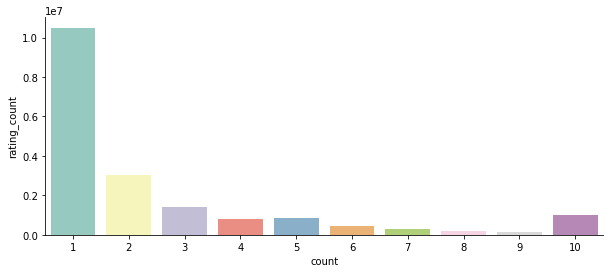

In [13]:
listen_counts = pd.DataFrame(df_song_reduced.groupby('count').size(), columns=['rating_count']).reset_index(drop=False)
display(df_song_reduced)

plt.figure(figsize=(10, 4))
sns.barplot(x='count', y='rating_count', palette='Set3', data=listen_counts)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show();

In [14]:
reader = Reader(rating_scale=(1, 10))
data = Dataset.load_from_df(df_song_reduced[['user_id', 'song_id_SPF', 'count']], reader)

In [15]:
trainset, testset = train_test_split(data, test_size=0.01)

In [6]:
param_grid = {'n_factors': [160], 
              'n_epochs': [10], 
              'lr_all': [0.001, 0.005],
              'reg_all': [0.08, 0.1]}

grid_search_svd = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=3, joblib_verbose=4, n_jobs=-2)

In [ ]:
# find the best parameters for the model
grid_search_svd.fit(data)
find_algo = grid_search_svd.best_estimator['rmse']
print(grid_search_svd.best_score['rmse'])
print(grid_search_svd.best_params['rmse'])

In [21]:
# Perform the cross validation - 1-10 scale
#cross_validate(find_algo, data, measures=['RMSE'], cv=5, verbose=True)
import time
start = time.perf_counter()
final_algorithm = SVD(n_factors=160, n_epochs=100, lr_all=0.005, reg_all=0.08)
final_algorithm.fit(trainset)
test_predictions = final_algorithm.test(testset)
print(f"The RMSE is {accuracy.rmse(test_predictions, verbose=True)}")
end = time.perf_counter()
print(end-start)

RMSE: 7.9182
The RMSE is 7.91817157626036
7291.902508549392


### Save Recommender Model to File

In [14]:
model_name = 'recommender_model_fitted'
#final_algorithm = SVD(n_factors=160, n_epochs=20, lr_all=0.005, reg_all=0.08)
dump.dump(model_name, predictions=None, algo=final_algorithm, verbose=0)